## 0. 옵션코드 별로 데이터프레임 나누기

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.ensemble import IsolationForest
# 한글 폰트 설정 (예: Malgun Gothic)
plt.rc('font', family='Malgun Gothic')
# 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [7]:
df=pd.read_excel('데이터2_반품 처리.xlsx')
df

,판매일,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류
0,2021-01-31,80135906,13,매출,51167,201736,EA,48,1,페레로로쉐(T-5),빵.케익.과자류,과자류,초콜릿류
1,2021-01-31,80974482,1,매출,51587,202449,EA,48,1,킨더조이(남아)1구20g,빵.케익.과자류,과자류,초콜릿류
2,2021-01-31,34000723423,1,매출,51575,202493,EA,4,1,(롯데제과)아이스브레이커스베리42g*8,빵.케익.과자류,과자류,캔디류
3,2021-01-31,34000723461,1,매출,51522,202574,CS,32,8,(롯데제과)아이스브레이커스민트42g,빵.케익.과자류,과자류,캔디류
4,2021-01-31,41689300494,8,매출,51174,202469,EA,NaN,1,지프기름,생활잡화,기타생활잡화,기타생활잡화
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183067,2023-12-30,38801052438017,3,매출,51157,201575,CS,20,20,(대상)순창양념쌈장사각500g,조미료류,장류,쌈장
183068,2023-12-30,48801236280972,10,매출,51730,200673,CS,4,4,(모나리자)녹스점보롤220m*4롤(파랑),일상용품,화장지류,두루마리화장지
183069,2023-12-30,58801056088243,1,매출,51421,200342,CS,12/6,6,(델몬트)델몬트매실1.5L,"음료,차류",음료,과즙·희석과즙음료
183070,2023-12-30,58801056089493,1,매출,51421,200342,CS,12/6,6,(델몬트)델몬트망고스카시1.5L,"음료,차류",음료,과즙·희석과즙음료


In [12]:
# '옵션코드' 값들을 통일
df['옵션코드'] = df['옵션코드'].replace({
    'BX2': 'BX',
    'BX3': 'BX',
    'BX4': 'BX'
})

# 값별 카운팅 결과 확인
option_counts = df['옵션코드'].value_counts()

print(option_counts)

옵션코드
EA    140280
CS     38720
BX      4072
Name: count, dtype: int64


In [17]:
# 옵션코드가 'EA'인 데이터프레임
df_EA = df[df['옵션코드'] == 'EA']

# 옵션코드가 'BX'인 데이터프레임
df_BX = df[df['옵션코드'] == 'BX']

# 옵션코드가 'CS'인 데이터프레임
df_CS = df[df['옵션코드'] == 'CS']

## 0. 주차별로 집계하기

In [18]:
# '판매일' 칼럼을 날짜 형식으로 변환
df_EA['판매일'] = pd.to_datetime(df_EA['판매일'])

# 1. '판매일'을 인덱스로 설정하여 주별로 그룹화
df_EA.set_index('판매일', inplace=True)

df1 = df_EA.resample('W-Mon').apply(
    lambda x: x.groupby('상품 바코드(대한상의)').agg({
        '판매수량': 'sum',      
        '구분': 'first',           
        '우편번호': 'first',
        '매출처코드': 'first',
        '옵션코드': 'first',
        '규격': 'first',
        '입수': 'first',
        '상품명': 'first',
        '대분류': 'first',
        '중분류': 'first',
        '소분류': 'first'
    }).assign(판매일=x.index[0] if len(x) > 0 else pd.NaT) 
)

# 2. 인덱스에 있는 '판매일'을 일반 칼럼으로 다시 되돌리기
df1 = df1.reset_index()

df1

/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_9747/4266211822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_EA['판매일'] = pd.to_datetime(df_EA['판매일'])


,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,80135906,13,매출,51167,201736,EA,48,1,페레로로쉐(T-5),빵.케익.과자류,과자류,초콜릿류,2021-01-31
1,80974482,1,매출,51587,202449,EA,48,1,킨더조이(남아)1구20g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
2,34000723423,1,매출,51575,202493,EA,4,1,(롯데제과)아이스브레이커스베리42g*8,빵.케익.과자류,과자류,캔디류,2021-01-31
3,41689300494,8,매출,51174,202469,EA,None,1,지프기름,생활잡화,기타생활잡화,기타생활잡화,2021-01-31
4,47400179349,1,매출,51130,200924,EA,6,1,(P&G)질레트마하3면도날4입,일상용품,위생용품,면도용품,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110241,18801045890491,1,매출,51357,200577,EA,1,1,(오뚜기)오뚜기밥210g*12,가공식품류,레토르트식품,밥·반찬류,2023-12-26
110242,18801119221114,13,매출,46725,203707,EA,1,1,(하이트진로)하이트제로355ml*24,"음료,차류",음료,기타음료,2023-12-26
110243,18801235231301,14,매출,51393,203840,EA,1,1,롯데종이컵1000개입,생활잡화,기타생활잡화,기타생활잡화,2023-12-26
110244,68801056008200,3,매출,51565,202790,EA,1,1,(델몬트)델몬트망고드링크팩190ml*4*8,"음료,차류",음료,과즙·희석과즙음료,2023-12-26


In [19]:
# '판매일' 칼럼을 날짜 형식으로 변환
df_BX['판매일'] = pd.to_datetime(df_BX['판매일'])

# 1. '판매일'을 인덱스로 설정하여 주별로 그룹화
df_BX.set_index('판매일', inplace=True)

df2 = df_BX.resample('W-Mon').apply(
    lambda x: x.groupby('상품 바코드(대한상의)').agg({
        '판매수량': 'sum',      
        '구분': 'first',           
        '우편번호': 'first',
        '매출처코드': 'first',
        '옵션코드': 'first',
        '규격': 'first',
        '입수': 'first',
        '상품명': 'first',
        '대분류': 'first',
        '중분류': 'first',
        '소분류': 'first'
    }).assign(판매일=x.index[0] if len(x) > 0 else pd.NaT) 
)

# 2. 인덱스에 있는 '판매일'을 일반 칼럼으로 다시 되돌리기
df2 = df2.reset_index()

df2

/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_9747/3388275051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BX['판매일'] = pd.to_datetime(df_BX['판매일'])


,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,8000500191033,1,매출,51768,202551,BX,48,48,킨더조이(남아)1구20g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
1,8801062640799,6,매출,51401,201062,BX,60,10,(롯데제과)크런키더블크런치바36g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
2,8803060081215,13,매출,51163,201573,BX,30,30,(백제물산)즉석쌀국수멸치맛92g,면류.라면류,면류,일반국수,2021-01-31
3,8803651000274,8,매출,51178,202466,BX,None,50,불티나,생활잡화,기타생활잡화,기타생활잡화,2021-01-31
4,8806002002583,26,매출,51152,200311,BX,10,10,(광동제약)비타500_100ml*10,"음료,차류",음료,기능성음료,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,48801062642081,1,매출,51401,200408,BX,20,20,(롯데제과)2400빈츠102g,빵.케익.과자류,과자류,스낵류,2023-12-26
3093,48801094502636,1,매출,50877,200205,BX,24,24,(코카콜라)조지아크래프트아메리카노470ml,"음료,차류",음료,기타커피및코코아,2023-12-26
3094,48801094512635,6,매출,50877,200205,BX,24,24,(코카콜라)조지아크래프트카페라떼470ml,"음료,차류",음료,기타커피및코코아,2023-12-26
3095,58801051230449,2,매출,51649,201622,BX,10,10,(LG생활)자연퐁솔잎설거지리필1.2kg,일상용품,세제용품,주거용세제,2023-12-26


In [20]:
# '판매일' 칼럼을 날짜 형식으로 변환
df_CS['판매일'] = pd.to_datetime(df_CS['판매일'])

# 1. '판매일'을 인덱스로 설정하여 주별로 그룹화
df_CS.set_index('판매일', inplace=True)

df3 = df_CS.resample('W-Mon').apply(
    lambda x: x.groupby('상품 바코드(대한상의)').agg({
        '판매수량': 'sum',      
        '구분': 'first',           
        '우편번호': 'first',
        '매출처코드': 'first',
        '옵션코드': 'first',
        '규격': 'first',
        '입수': 'first',
        '상품명': 'first',
        '대분류': 'first',
        '중분류': 'first',
        '소분류': 'first'
    }).assign(판매일=x.index[0] if len(x) > 0 else pd.NaT) 
)

# 2. 인덱스에 있는 '판매일'을 일반 칼럼으로 다시 되돌리기
df3 = df3.reset_index()

df3

/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_9747/2476161546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CS['판매일'] = pd.to_datetime(df_CS['판매일'])


,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,34000723461,1,매출,51522,202574,CS,32,8,(롯데제과)아이스브레이커스민트42g,빵.케익.과자류,과자류,캔디류,2021-01-31
1,6921211116189,1,매출,51268,201813,CS,10,10,(농심)츄파춥스하트젤리복숭아크림향60g,빵.케익.과자류,과자류,캔디류,2021-01-31
2,8000500168028,2,매출,41836,200063,CS,48,24,킨더조이(남아)1구20g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
3,8000500168042,5,매출,51191,202522,CS,48,24,킨더조이(여아)1구20g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
4,8717644460870,1,매출,51731,202105,CS,12,12,(유니레버)도브핸드워시(레귤러)250ml,일상용품,세제용품,기타비누세제류,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28484,68801051275133,7,매출,51357,200853,CS,3,3,(LG생활)샤프란핑크리필2.1L*2밴딩(3)_22Y,일상용품,세제용품,유연제,2023-12-26
28485,68801056071235,1,매출,51502,202765,CS,20,20,(델몬트)오리지널오렌지100_400ml,"음료,차류",음료,천연과즙음료,2023-12-26
28486,68801056071273,2,매출,51502,202765,CS,20,20,(델몬트)오리지널망고400ml,"음료,차류",음료,과즙·희석과즙음료,2023-12-26
28487,68801056090274,2,매출,52009,200817,CS,20/6,6,(롯데칠성)게토레이레몬600ml,"음료,차류",음료,스포츠음료,2023-12-26


## 1. df1(EA) 이상치 파악하기

### 1. IQR 사분위

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANG

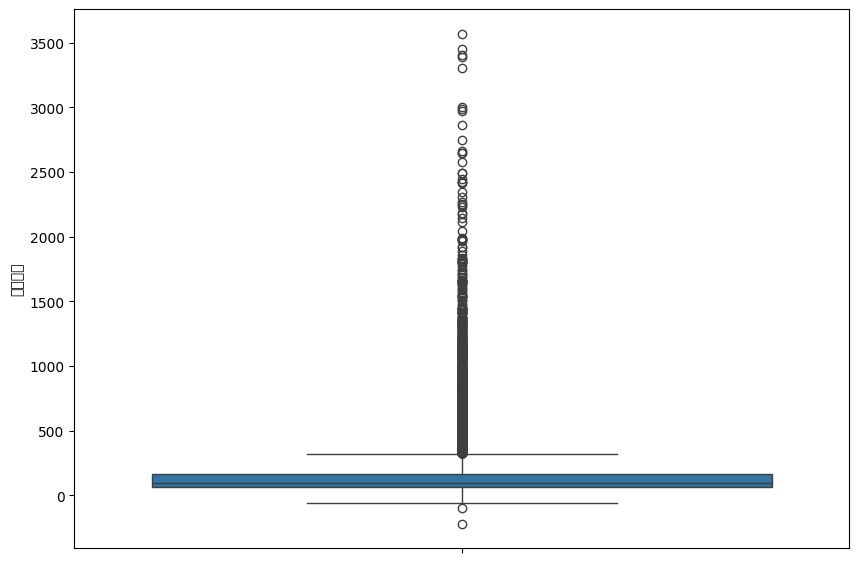

In [21]:
#Q1 Q2의 값을 만들기
Q1 = df1['판매수량'].quantile(0.25)
Q3 = df1['판매수량'].quantile(0.75)

#IQR 만들기
IQR = Q3- Q1

# 이상치 범위 조절
out_range=1.5

# 이상치 범위 설정
outlier_range = (df1['판매수량'] < Q1 - out_range * IQR) | (df1['판매수량'] > Q3 + out_range * IQR)

# 이상치 데이터 선택
df1_outliers1 = df1.loc[outlier_range]

# 이상치만 시각화
plt.figure(figsize=(10,7))
sns.boxplot(y='판매수량', data=df1_outliers1)
plt.show()

In [22]:
#df1(EA)에서 이상치인 행들
df1_outliers1

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
7,2880934881931,55,매출,53075,202364,EA,1,1,신안천일염20kg,조미료류,조미식품,식염,2021-01-31
14,4001686301555,48,매출,41846,200157,EA,30/26/10,1,(수입과자)하리보골드바렌100g,빵.케익.과자류,과자류,기타과자,2021-01-31
21,4897036691007,144,매출,50855,200097,EA,24,1,(코카콜라)몬스터에너지그린355ml,"음료,차류",음료,기능성음료,2021-01-31
29,4902430311625,167,매출,41846,200157,EA,12,1,(P&G)다우니핑크베리베리와바닐라크림향1L,일상용품,세제용품,유연제,2021-01-31
30,4902430311670,73,매출,41846,200157,EA,12,1,(P&G)다우니퍼플화이트티와릴리향1L,일상용품,세제용품,유연제,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110174,8809274240219,322,매출,51492,203930,EA,1,1,(하이얏트)가야산천년수2L*6,"음료,차류",음료,생수,2023-12-26
110198,8809416303451,54,매출,51418,203951,EA,3,1,(쌍용)코디에코스마트22m*30롤,일상용품,화장지류,두루마리화장지,2023-12-26
110200,8809420331365,153,매출,41958,200630,EA,10,1,미룡구운달콤한쌀과자275g,빵.케익.과자류,과자류,None,2023-12-26
110224,8809846320011,157,매출,51427,201872,EA,72,1,(한빛)위생종이컵1000개입,생활잡화,기타생활잡화,None,2023-12-26


### 2. Standard Deviation Method

In [23]:
def out_std(df, column):
    global lower, upper #전역 변수로 lower와 upper 지정
    data_mean, data_std = df[column].mean(), df[column].std()
    
    cut_off = data_std *3
    # 평균에 빼고 더해서 , 범위 정하기
    lower, upper = data_mean - cut_off, data_mean +cut_off
    print('lower',lower)
    print('upper',upper)
    
    df_upp = df[df[column]>upper]
    df_low = df[df[column]<lower]
    
    return print('Outlier', df_upp.shape[0] + df_low.shape[0])

In [24]:
out_std(df1, '판매수량')

lower -270.8321284050318
upper 329.3907699883999
Outlier 1405


/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_9747/1315553468.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['판매수량'], kde=False)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE

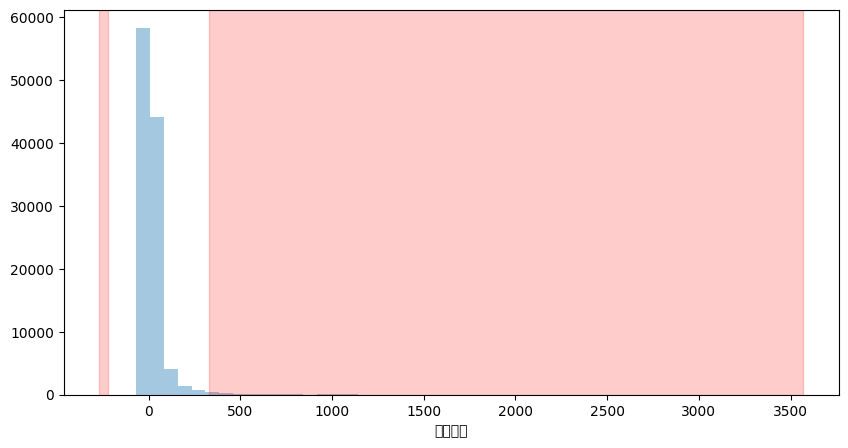

In [25]:
plt.figure(figsize=(10,5))
sns.distplot(df1['판매수량'], kde=False)
plt.axvspan(xmin = lower, xmax = df1['판매수량'].min(), alpha=0.2, color='red')
plt.axvspan(xmin = upper, xmax = df1['판매수량'].max(), alpha=0.2, color='red')

In [26]:
# outlier data
df1_outliers2 = df1[(df1['판매수량']>upper) | (df1['판매수량']< lower)]

In [27]:
#outlier데이터만 추출
df1_outliers2

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
161,8801007402291,645,매출,41846,200744,EA,20,1,(백설)식용유900ml,조미료류,식용유,콩기름(대두유),2021-01-31
162,8801007402345,552,매출,41958,200630,EA,10,1,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
392,8801039202371,621,매출,41810,200442,EA,12,1,(사조해표)해표식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
393,8801039202388,490,매출,41810,200442,EA,8,1,(사조해표)해표식용유1.5L,조미료류,식용유,콩기름(대두유),2021-01-31
438,8801043015684,820,매출,27140,201208,EA,1,1,(농심)육개장사발면컵6입,면류.라면류,라면류,용기라면,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109651,8801056040925,408,매출,51370,98,EA,24,1,(롯데칠성)칠성사이다355ml,"음료,차류",음료,탄산음료,2023-12-26
109731,8801094016203,361,매출,51376,202892,EA,24,1,(코카콜라)코카콜라(슈퍼용)355ml,"음료,차류",음료,탄산음료,2023-12-26
109747,8801094513009,600,매출,51570,203472,EA,30,1,(코카콜라)조지아카페라떼240ml,"음료,차류",음료,캔커피,2023-12-26
110015,8804782001611,350,매출,51537,201727,EA,30,1,(제주농원)추억건빵155g,빵.케익.과자류,과자류,스낵류,2023-12-26


### 3. Z-score method

In [28]:
def out_zscore(data):
    global outliers, zscore
    #outlier 변수 담기 
    outliers =[]
    zscore= []
    
    #평균, 분산, threshold 지정
    threshold = 2
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i- mean)/std
        zscore.append(z_score)
        if np.abs(z_score)> threshold:
            outliers.append(i)
    return outliers

In [29]:
outlier_values=out_zscore(df1.판매수량)

/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_9747/2248039830.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zscore)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

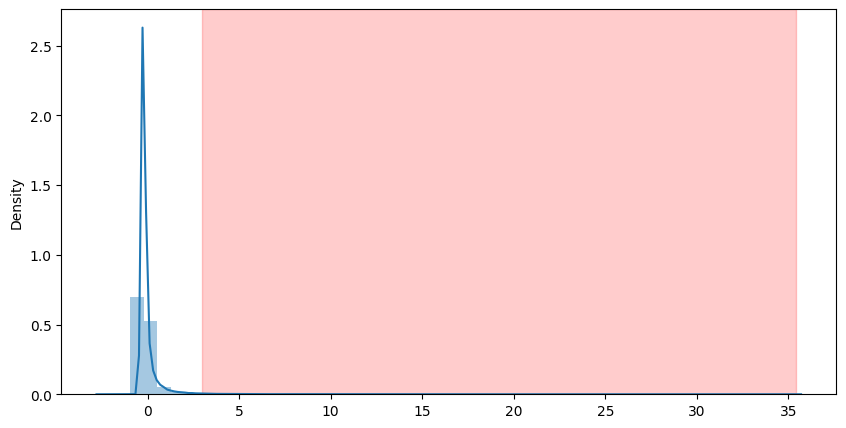

In [30]:
plt.figure(figsize=(10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3, xmax = max(zscore), alpha=0.2, color='red')

In [31]:
# 이상치인 데이터만 추출
df1_outliers3 = df1[df1['판매수량'].isin(outlier_values)]

df1_outliers3

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
114,8801007102238,248,매출,41846,200594,EA,8/6,1,(백설)하얀설탕3kg,조미료류,조미식품,설탕,2021-01-31
161,8801007402291,645,매출,41846,200744,EA,20,1,(백설)식용유900ml,조미료류,식용유,콩기름(대두유),2021-01-31
162,8801007402345,552,매출,41958,200630,EA,10,1,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
234,8801037006391,235,매출,53075,202364,EA,24(20+10T),1,(동서식품)맥심모카골드믹스20T,"음료,차류",음료,커피믹스,2021-01-31
294,8801037048186,265,매출,63187,200435,EA,24,1,(동서식품)맥심모카골드믹스20T,"음료,차류",음료,커피믹스,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109747,8801094513009,600,매출,51570,203472,EA,30,1,(코카콜라)조지아카페라떼240ml,"음료,차류",음료,캔커피,2023-12-26
110015,8804782001611,350,매출,51537,201727,EA,30,1,(제주농원)추억건빵155g,빵.케익.과자류,과자류,스낵류,2023-12-26
110080,8809015450310,250,매출,51425,59,EA,40,1,(동서)단단하고향이좋은로즈비누150g,일상용품,위생용품,세안용품,2023-12-26
110134,8809170703177,352,매출,51361,203146,EA,20/10,1,아망아망베이직물티슈캡형100매,일상용품,화장지류,물수건,2023-12-26


### 4. Isolation Forest

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/

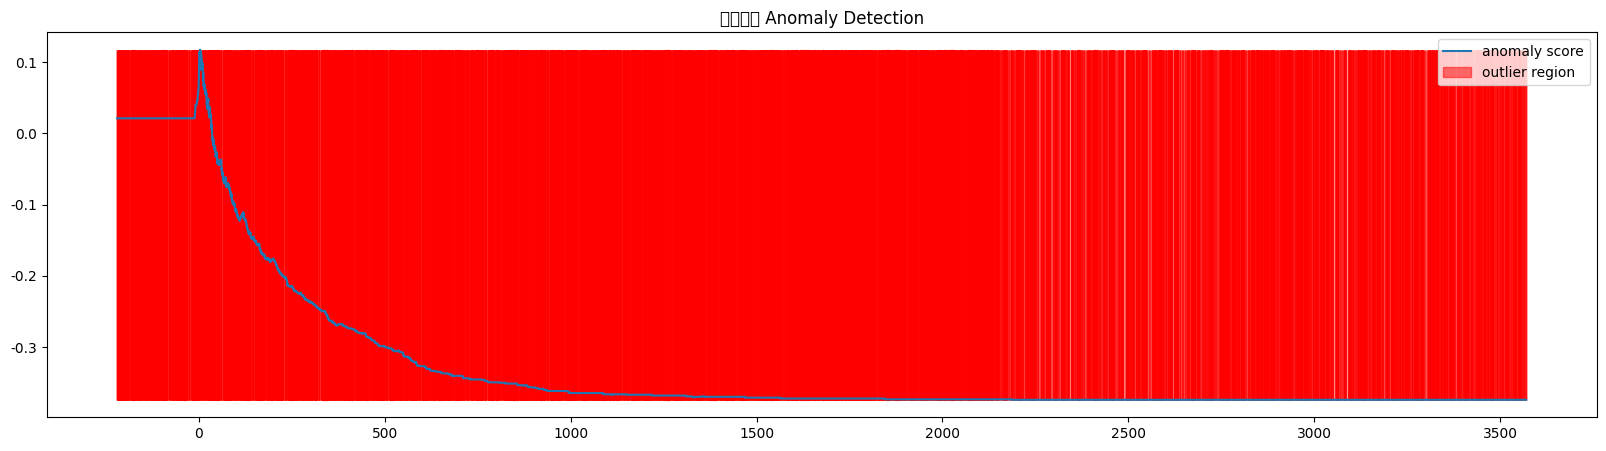

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
7,2880934881931,55,매출,53075,202364,EA,1,1,신안천일염20kg,조미료류,조미식품,식염,2021-01-31
14,4001686301555,48,매출,41846,200157,EA,30/26/10,1,(수입과자)하리보골드바렌100g,빵.케익.과자류,과자류,기타과자,2021-01-31
21,4897036691007,144,매출,50855,200097,EA,24,1,(코카콜라)몬스터에너지그린355ml,"음료,차류",음료,기능성음료,2021-01-31
26,4902430113304,43,매출,52852,201649,EA,24/12,1,(P&G)페브리즈상쾌한향(리필)320ml,일상용품,방향제류,기타방향용제품류,2021-01-31
29,4902430311625,167,매출,41846,200157,EA,12,1,(P&G)다우니핑크베리베리와바닐라크림향1L,일상용품,세제용품,유연제,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110174,8809274240219,322,매출,51492,203930,EA,1,1,(하이얏트)가야산천년수2L*6,"음료,차류",음료,생수,2023-12-26
110198,8809416303451,54,매출,51418,203951,EA,3,1,(쌍용)코디에코스마트22m*30롤,일상용품,화장지류,두루마리화장지,2023-12-26
110200,8809420331365,153,매출,41958,200630,EA,10,1,미룡구운달콤한쌀과자275g,빵.케익.과자류,과자류,None,2023-12-26
110224,8809846320011,157,매출,51427,201872,EA,72,1,(한빛)위생종이컵1000개입,생활잡화,기타생활잡화,None,2023-12-26


In [32]:
cols = ['판매수량']

# 그래프를 그리기 위해서 subplot 생성
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', edgecolor='k')

# Isolation Forest 모델 학습
isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(df1[cols].values.reshape(-1, 1))

# 이상치 탐지를 위한 예측
outlier = isolation_forest.predict(df1[cols].values.reshape(-1, 1))

# 이상치 점수 계산
xx = np.linspace(df1['판매수량'].min(), df1['판매수량'].max(), len(df1)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)

# 그래프 그리기
ax.plot(xx, anomaly_score, label='anomaly score')
ax.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                where=outlier == -1, color='r', alpha=0.5, label='outlier region')
ax.legend()
ax.set_title('판매수량 Anomaly Detection')
plt.show()

# 이상치 데이터 행 출력
df1_outliers4 = df1[outlier == -1]
df1_outliers4

## 공통 이상치만 출력 -> 공통 이상치 제외한 데이터프레임 생성

In [33]:
common_outliers1 = df1_outliers1.merge(df1_outliers2, on=list(df1_outliers1.columns), how='inner') \
                                 .merge(df1_outliers3, on=list(df1_outliers1.columns), how='inner') \
                                 .merge(df1_outliers4, on=list(df1_outliers1.columns), how='inner')

common_outliers1

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,8801007402291,645,매출,41846,200744,EA,20,1,(백설)식용유900ml,조미료류,식용유,콩기름(대두유),2021-01-31
1,8801007402345,552,매출,41958,200630,EA,10,1,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
2,8801039202371,621,매출,41810,200442,EA,12,1,(사조해표)해표식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
3,8801039202388,490,매출,41810,200442,EA,8,1,(사조해표)해표식용유1.5L,조미료류,식용유,콩기름(대두유),2021-01-31
4,8801043015684,820,매출,27140,201208,EA,1,1,(농심)육개장사발면컵6입,면류.라면류,라면류,용기라면,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,8801056040925,408,매출,51370,98,EA,24,1,(롯데칠성)칠성사이다355ml,"음료,차류",음료,탄산음료,2023-12-26
1401,8801094016203,361,매출,51376,202892,EA,24,1,(코카콜라)코카콜라(슈퍼용)355ml,"음료,차류",음료,탄산음료,2023-12-26
1402,8801094513009,600,매출,51570,203472,EA,30,1,(코카콜라)조지아카페라떼240ml,"음료,차류",음료,캔커피,2023-12-26
1403,8804782001611,350,매출,51537,201727,EA,30,1,(제주농원)추억건빵155g,빵.케익.과자류,과자류,스낵류,2023-12-26


In [34]:
# common_outliers1에 포함된 행을 df1에서 제거
df1_cleaned = df1.merge(common_outliers1, on=list(df1.columns), how='left', indicator=True)
df1_cleaned = df1_cleaned[df1_cleaned['_merge'] == 'left_only'].drop(columns=['_merge'])

df1_cleaned

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,80135906,13,매출,51167,201736,EA,48,1,페레로로쉐(T-5),빵.케익.과자류,과자류,초콜릿류,2021-01-31
1,80974482,1,매출,51587,202449,EA,48,1,킨더조이(남아)1구20g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
2,34000723423,1,매출,51575,202493,EA,4,1,(롯데제과)아이스브레이커스베리42g*8,빵.케익.과자류,과자류,캔디류,2021-01-31
3,41689300494,8,매출,51174,202469,EA,None,1,지프기름,생활잡화,기타생활잡화,기타생활잡화,2021-01-31
4,47400179349,1,매출,51130,200924,EA,6,1,(P&G)질레트마하3면도날4입,일상용품,위생용품,면도용품,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110241,18801045890491,1,매출,51357,200577,EA,1,1,(오뚜기)오뚜기밥210g*12,가공식품류,레토르트식품,밥·반찬류,2023-12-26
110242,18801119221114,13,매출,46725,203707,EA,1,1,(하이트진로)하이트제로355ml*24,"음료,차류",음료,기타음료,2023-12-26
110243,18801235231301,14,매출,51393,203840,EA,1,1,롯데종이컵1000개입,생활잡화,기타생활잡화,기타생활잡화,2023-12-26
110244,68801056008200,3,매출,51565,202790,EA,1,1,(델몬트)델몬트망고드링크팩190ml*4*8,"음료,차류",음료,과즙·희석과즙음료,2023-12-26


In [35]:
# 엑셀 파일로 저장
df1_cleaned.to_excel('(2데이터)EA 이상치 제외_주 단위.xlsx', index=False)

## 2. df2(BX) 이상치 파악하기

### 1. IQR 사분위

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANG

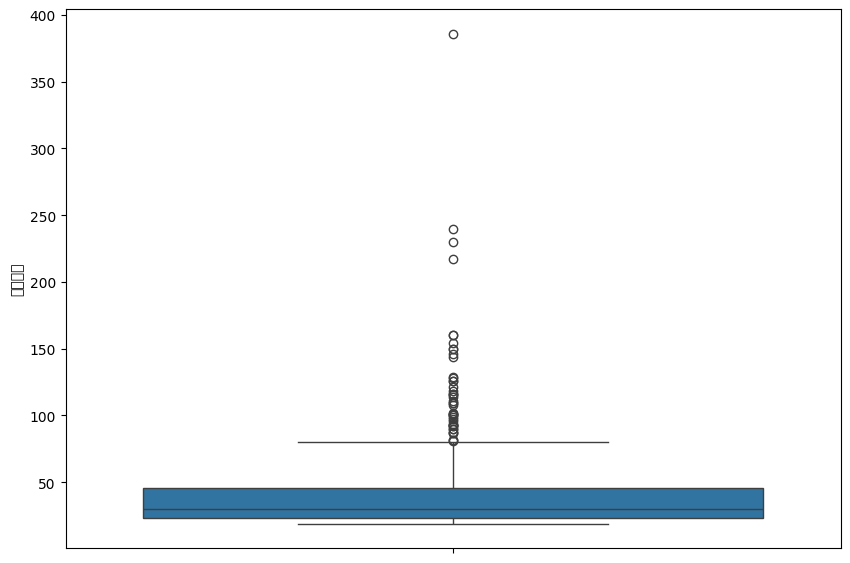

In [36]:
#Q1 Q2의 값을 만들기
Q1 = df2['판매수량'].quantile(0.25)
Q3 = df2['판매수량'].quantile(0.75)

#IQR 만들기
IQR = Q3- Q1

# 이상치 범위 조절
out_range=1.5

# 이상치 범위 설정
outlier_range = (df2['판매수량'] < Q1 - out_range * IQR) | (df2['판매수량'] > Q3 + out_range * IQR)

# 이상치 데이터 선택
df2_outliers1 = df2.loc[outlier_range]

# 이상치만 시각화
plt.figure(figsize=(10,7))
sns.boxplot(y='판매수량', data=df2_outliers1)
plt.show()

In [37]:
#df2(BX)에서 이상치인 행들
df2_outliers1

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
4,8806002002583,26,매출,51152,200311,BX,10,10,(광동제약)비타500_100ml*10,"음료,차류",음료,기능성음료,2021-01-31
14,18801007299126,92,매출,51607,202214,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
20,18801045523429,20,매출,51596,200051,BX,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
33,18801073320755,20,매출,51170,200046,BX,10/20,20,(삼양식품)사또밥67g,빵.케익.과자류,과자류,스낵류,2021-01-31
34,18801097150031,21,매출,51147,202236,BX,12,12,(동아오츠카)포카리스웨트1.5L,"음료,차류",음료,스포츠음료,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,18801045523429,29,매출,51690,200486,BX,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-12-19
3056,18801105956822,22,매출,51575,200165,BX,3/4,3,(해태음료)구론산오리지널150ml*10,"음료,차류",음료,기능성음료,2023-12-19
3069,8801043024464,21,매출,51245,202354,BX,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2023-12-26
3074,18801007299126,29,매출,51277,200321,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2023-12-26


### 2. Standard Deviation Method

In [38]:
def out_std(df, column):
    global lower, upper #전역 변수로 lower와 upper 지정
    data_mean, data_std = df[column].mean(), df[column].std()
    
    cut_off = data_std *3
    # 평균에 빼고 더해서 , 범위 정하기
    lower, upper = data_mean - cut_off, data_mean +cut_off
    print('lower',lower)
    print('upper',upper)
    
    df_upp = df[df[column]>upper]
    df_low = df[df[column]<lower]
    
    return print('Outlier', df_upp.shape[0] + df_low.shape[0])

In [39]:
out_std(df2, '판매수량')

lower -47.470590375686506
upper 64.63429718873138
Outlier 64


/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_9747/3522138605.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2['판매수량'], kde=False)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  func(*args, **kwargs)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  func(*args, **kwargs)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/

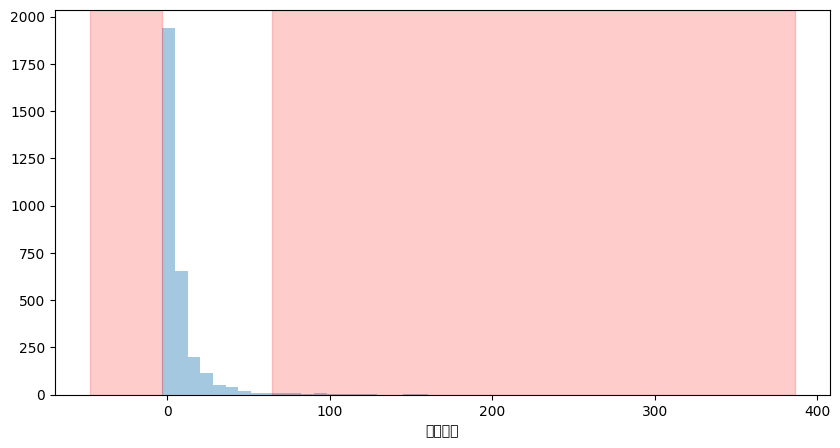

In [40]:
plt.figure(figsize=(10,5))
sns.distplot(df2['판매수량'], kde=False)
plt.axvspan(xmin = lower, xmax = df2['판매수량'].min(), alpha=0.2, color='red')
plt.axvspan(xmin = upper, xmax = df2['판매수량'].max(), alpha=0.2, color='red')

In [41]:
# outlier data
df2_outliers2 = df2[(df2['판매수량']>upper) | (df2['판매수량']< lower)]

In [42]:
#outlier데이터만 추출
df2_outliers2

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
14,18801007299126,92,매출,51607,202214,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
49,28806011615402,92,매출,51632,200190,BX,10,10,(동아제약)박카스F120ml*10,"음료,차류",음료,기능성음료,2021-01-31
83,18801007299126,111,매출,51640,202371,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-02-28
122,28806011615402,87,매출,51568,202549,BX,10,10,(동아제약)박카스F120ml*10,"음료,차류",음료,기능성음료,2021-02-28
191,28806011615402,116,매출,51492,201844,BX,10,10,(동아제약)박카스F120ml*10,"음료,차류",음료,기능성음료,2021-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,68801056049210,80,매출,51693,204024,BX,20/6,20,(롯데칠성)게토레이레몬600ml,"음료,차류",음료,스포츠음료,2023-05-16
2419,18801045523412,154,매출,51277,200321,BX,8,8,(오뚜기)진라면순한맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-08-15
2583,8801043024464,67,매출,51366,202144,BX,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2023-09-19
2731,18801045523429,78,매출,51425,59,BX,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-10-17


### 3. Z-score method

In [43]:
def out_zscore(data):
    global outliers, zscore
    #outlier 변수 담기 
    outliers =[]
    zscore= []
    
    #평균, 분산, threshold 지정
    threshold = 2
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i- mean)/std
        zscore.append(z_score)
        if np.abs(z_score)> threshold:
            outliers.append(i)
    return outliers

In [44]:
outlier_values=out_zscore(df2.판매수량)

/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_9747/2248039830.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zscore)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

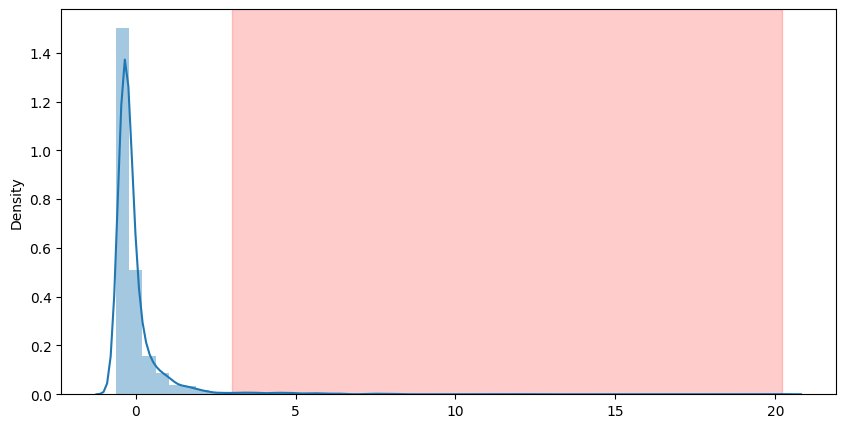

In [45]:
plt.figure(figsize=(10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3, xmax = max(zscore), alpha=0.2, color='red')

In [46]:
# 이상치인 데이터만 추출
df2_outliers3 = df2[df2['판매수량'].isin(outlier_values)]

df2_outliers3

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
14,18801007299126,92,매출,51607,202214,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
49,28806011615402,92,매출,51632,200190,BX,10,10,(동아제약)박카스F120ml*10,"음료,차류",음료,기능성음료,2021-01-31
83,18801007299126,111,매출,51640,202371,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-02-28
122,28806011615402,87,매출,51568,202549,BX,10,10,(동아제약)박카스F120ml*10,"음료,차류",음료,기능성음료,2021-02-28
180,18801223100503,55,매출,51174,202469,BX,30,30,(일화)맥콜캔250ml,"음료,차류",음료,탄산음료,2021-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2688,18801045200528,59,매출,51231,202310,BX,6,6,(오뚜기)양조식초1.8L,조미료류,조미식품,식초,2023-10-10
2731,18801045523429,78,매출,51425,59,BX,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-10-17
2813,18801105956822,50,매출,50875,201259,BX,3/4,3,(해태음료)구론산오리지널150ml*10,"음료,차류",음료,기능성음료,2023-10-31
2814,18801105957232,46,매출,50875,201259,BX,3/4,3,(해태음료)구론산탄산오리지널150ml*10,"음료,차류",음료,기능성음료,2023-10-31


### 4. Isolation Forest

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/

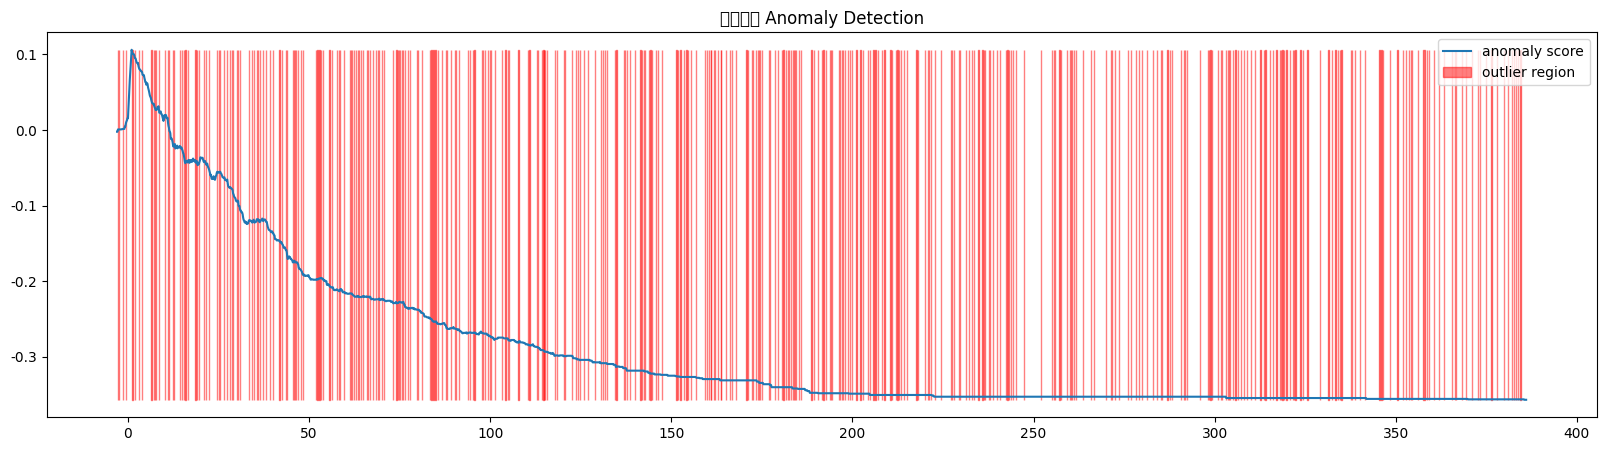

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
2,8803060081215,13,매출,51163,201573,BX,30,30,(백제물산)즉석쌀국수멸치맛92g,면류.라면류,면류,일반국수,2021-01-31
4,8806002002583,26,매출,51152,200311,BX,10,10,(광동제약)비타500_100ml*10,"음료,차류",음료,기능성음료,2021-01-31
14,18801007299126,92,매출,51607,202214,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
20,18801045523429,20,매출,51596,200051,BX,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
32,18801069218059,12,매출,50870,200195,BX,10,10,(남양)프렌치카페모카초코컵(초록)200ml,"음료,차류",음료,캔커피,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,8801043024464,21,매출,51245,202354,BX,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2023-12-26
3074,18801007299126,29,매출,51277,200321,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2023-12-26
3079,18801045523429,28,매출,51277,200321,BX,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-12-26
3083,18801105956822,14,매출,50877,200205,BX,3/4,3,(해태음료)구론산오리지널150ml*10,"음료,차류",음료,기능성음료,2023-12-26


In [47]:
cols = ['판매수량']

# 그래프를 그리기 위해서 subplot 생성
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', edgecolor='k')

# Isolation Forest 모델 학습
isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(df2[cols].values.reshape(-1, 1))

# 이상치 탐지를 위한 예측
outlier = isolation_forest.predict(df2[cols].values.reshape(-1, 1))

# 이상치 점수 계산
xx = np.linspace(df2['판매수량'].min(), df2['판매수량'].max(), len(df2)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)

# 그래프 그리기
ax.plot(xx, anomaly_score, label='anomaly score')
ax.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                where=outlier == -1, color='r', alpha=0.5, label='outlier region')
ax.legend()
ax.set_title('판매수량 Anomaly Detection')
plt.show()

# 이상치 데이터 행 출력
df2_outliers4 = df2[outlier == -1]
df2_outliers4

## 공통 이상치만 출력 -> 공통 이상치 제외한 데이터프레임 생성

In [48]:
common_outliers2 = df2_outliers1.merge(df2_outliers2, on=list(df2_outliers1.columns), how='inner') \
                                 .merge(df2_outliers3, on=list(df2_outliers1.columns), how='inner') \
                                 .merge(df2_outliers4, on=list(df2_outliers1.columns), how='inner')

common_outliers2

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,18801007299126,92,매출,51607,202214,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-01-31
1,28806011615402,92,매출,51632,200190,BX,10,10,(동아제약)박카스F120ml*10,"음료,차류",음료,기능성음료,2021-01-31
2,18801007299126,111,매출,51640,202371,BX,10,10,(백설)콩식용유1.8L,조미료류,식용유,콩기름(대두유),2021-02-28
3,28806011615402,87,매출,51568,202549,BX,10,10,(동아제약)박카스F120ml*10,"음료,차류",음료,기능성음료,2021-02-28
4,28806011615402,116,매출,51492,201844,BX,10,10,(동아제약)박카스F120ml*10,"음료,차류",음료,기능성음료,2021-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,68801056049210,80,매출,51693,204024,BX,20/6,20,(롯데칠성)게토레이레몬600ml,"음료,차류",음료,스포츠음료,2023-05-16
60,18801045523412,154,매출,51277,200321,BX,8,8,(오뚜기)진라면순한맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-08-15
61,8801043024464,67,매출,51366,202144,BX,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2023-09-19
62,18801045523429,78,매출,51425,59,BX,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-10-17


In [49]:
# common_outliers2에 포함된 행을 df2에서 제거
df2_cleaned = df2.merge(common_outliers2, on=list(df2.columns), how='left', indicator=True)
df2_cleaned = df2_cleaned[df2_cleaned['_merge'] == 'left_only'].drop(columns=['_merge'])

df2_cleaned

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,8000500191033,1,매출,51768,202551,BX,48,48,킨더조이(남아)1구20g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
1,8801062640799,6,매출,51401,201062,BX,60,10,(롯데제과)크런키더블크런치바36g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
2,8803060081215,13,매출,51163,201573,BX,30,30,(백제물산)즉석쌀국수멸치맛92g,면류.라면류,면류,일반국수,2021-01-31
3,8803651000274,8,매출,51178,202466,BX,None,50,불티나,생활잡화,기타생활잡화,기타생활잡화,2021-01-31
4,8806002002583,26,매출,51152,200311,BX,10,10,(광동제약)비타500_100ml*10,"음료,차류",음료,기능성음료,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,48801062642081,1,매출,51401,200408,BX,20,20,(롯데제과)2400빈츠102g,빵.케익.과자류,과자류,스낵류,2023-12-26
3093,48801094502636,1,매출,50877,200205,BX,24,24,(코카콜라)조지아크래프트아메리카노470ml,"음료,차류",음료,기타커피및코코아,2023-12-26
3094,48801094512635,6,매출,50877,200205,BX,24,24,(코카콜라)조지아크래프트카페라떼470ml,"음료,차류",음료,기타커피및코코아,2023-12-26
3095,58801051230449,2,매출,51649,201622,BX,10,10,(LG생활)자연퐁솔잎설거지리필1.2kg,일상용품,세제용품,주거용세제,2023-12-26


In [50]:
# 엑셀 파일로 저장
df2_cleaned.to_excel('(2데이터)BX 이상치 제외_주 단위.xlsx', index=False)

## 3. df3(CS) 이상치 파악하기

### 1. IQR 사분위

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pyl

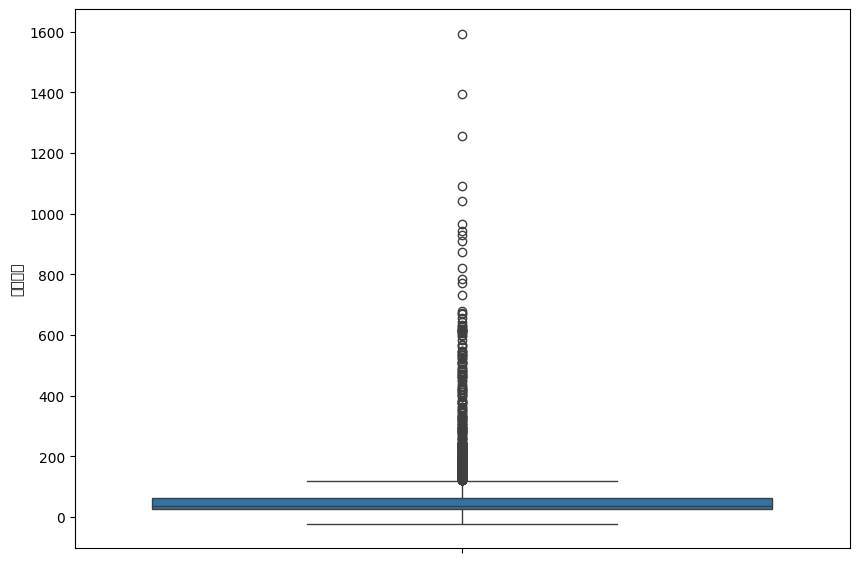

In [51]:
#Q1 Q2의 값을 만들기
Q1 = df3['판매수량'].quantile(0.25)
Q3 = df3['판매수량'].quantile(0.75)

#IQR 만들기
IQR = Q3- Q1

# 이상치 범위 조절
out_range=1.5

# 이상치 범위 설정
outlier_range = (df3['판매수량'] < Q1 - out_range * IQR) | (df3['판매수량'] > Q3 + out_range * IQR)

# 이상치 데이터 선택
df3_outliers1 = df3.loc[outlier_range]

# 이상치만 시각화
plt.figure(figsize=(10,7))
sns.boxplot(y='판매수량', data=df3_outliers1)
plt.show()

In [52]:
#df3(CS)에서 이상치인 행들
df3_outliers1

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
5,8801007070179,22,매출,51106,202537,CS,50,10,(CJ)헛개컨디션100ml,"음료,차류",음료,기능성음료,2021-01-31
9,8801019206825,24,매출,51106,201066,CS,144,12,(해태제과)1000자유시간36g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
19,8801043014793,632,매출,49409,201928,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2021-01-31
20,8801043014847,545,매출,49409,201928,CS,8,8,(농심)신라면멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
22,8801043015028,41,매출,49409,201928,CS,8,8,(농심)얼큰한너구리멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28398,18801046979492,23,매출,51669,200047,CS,12,12,(애경)항균트리오1kg,일상용품,세제용품,주방용합성세제,2023-12-26
28406,18801073181905,53,매출,51166,200996,CS,8,8,(삼양식품)삼양라면멀티120g*5,면류.라면류,라면류,봉지라면,2023-12-26
28408,18801073222219,47,매출,51203,200902,CS,16,16,(삼양식품)까르보불닭볶음면큰컵105g,면류.라면류,기타라면.면류,기타라면.면류,2023-12-26
28456,18809170703174,27,매출,51521,201637,CS,20/10,10,아망아망베이직물티슈캡형100매,일상용품,화장지류,물수건,2023-12-26


### 2. Standard Deviation Method

In [53]:
def out_std(df, column):
    global lower, upper #전역 변수로 lower와 upper 지정
    data_mean, data_std = df[column].mean(), df[column].std()
    
    cut_off = data_std *3
    # 평균에 빼고 더해서 , 범위 정하기
    lower, upper = data_mean - cut_off, data_mean +cut_off
    print('lower',lower)
    print('upper',upper)
    
    df_upp = df[df[column]>upper]
    df_low = df[df[column]<lower]
    
    return print('Outlier', df_upp.shape[0] + df_low.shape[0])

In [54]:
out_std(df3, '판매수량')

lower -114.57716802109431
upper 138.97360173235128
Outlier 346


/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_9747/608582794.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3['판매수량'], kde=False)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  func(*args, **kwargs)
/Users/kook/myenv/lib/python3.12/site-pa

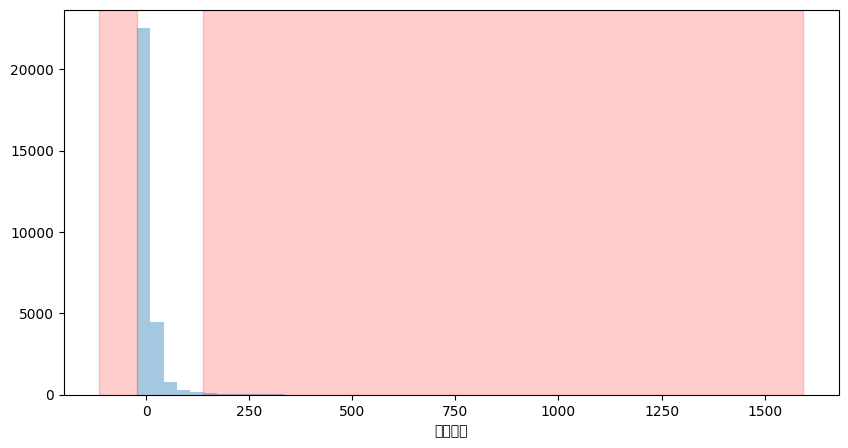

In [55]:
plt.figure(figsize=(10,5))
sns.distplot(df3['판매수량'], kde=False)
plt.axvspan(xmin = lower, xmax = df3['판매수량'].min(), alpha=0.2, color='red')
plt.axvspan(xmin = upper, xmax = df3['판매수량'].max(), alpha=0.2, color='red')

In [56]:
# outlier data
df3_outliers2 = df3[(df3['판매수량']>upper) | (df3['판매수량']< lower)]

In [57]:
#outlier데이터만 추출
df3_outliers2

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
19,8801043014793,632,매출,49409,201928,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2021-01-31
20,8801043014847,545,매출,49409,201928,CS,8,8,(농심)신라면멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
250,18801007424122,238,매출,50300,200531,CS,6,6,(CJ)햇반200g*6,가공식품류,레토르트식품,밥·반찬류,2021-01-31
308,18801037087540,140,매출,50855,200097,CS,24/20,20,(동서식품)TOP마스터라떼275ml,"음료,차류",음료,캔커피,2021-01-31
355,18801045522255,283,매출,50430,202595,CS,8,8,(오뚜기)진라면순한맛멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27317,18801045522286,242,매출,51163,202575,CS,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-11-28
27450,8801043014793,182,매출,51527,202960,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2023-12-05
27722,8801043014793,238,매출,51402,200040,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2023-12-12
27839,18801045522286,279,매출,51402,201502,CS,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-12-12


### 3. Z-score method

In [58]:
def out_zscore(data):
    global outliers, zscore
    #outlier 변수 담기 
    outliers =[]
    zscore= []
    
    #평균, 분산, threshold 지정
    threshold = 2
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i- mean)/std
        zscore.append(z_score)
        if np.abs(z_score)> threshold:
            outliers.append(i)
    return outliers

In [59]:
outlier_values=out_zscore(df3.판매수량)

/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_9747/2248039830.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zscore)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

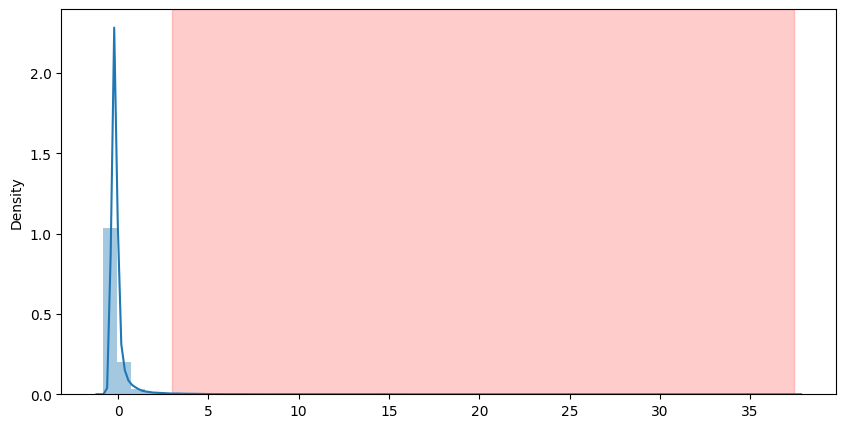

In [60]:
plt.figure(figsize=(10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3, xmax = max(zscore), alpha=0.2, color='red')

In [61]:
# 이상치인 데이터만 추출
df3_outliers3 = df3[df3['판매수량'].isin(outlier_values)]

df3_outliers3

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
19,8801043014793,632,매출,49409,201928,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2021-01-31
20,8801043014847,545,매출,49409,201928,CS,8,8,(농심)신라면멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
250,18801007424122,238,매출,50300,200531,CS,6,6,(CJ)햇반200g*6,가공식품류,레토르트식품,밥·반찬류,2021-01-31
308,18801037087540,140,매출,50855,200097,CS,24/20,20,(동서식품)TOP마스터라떼275ml,"음료,차류",음료,캔커피,2021-01-31
355,18801045522255,283,매출,50430,202595,CS,8,8,(오뚜기)진라면순한맛멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28140,18801073181905,285,매출,51167,203861,CS,8,8,(삼양식품)삼양라면멀티120g*5,면류.라면류,라면류,봉지라면,2023-12-19
28235,8801043014793,105,매출,51193,84,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2023-12-26
28316,8806002001869,110,매출,51393,202935,CS,10,2,(광동제약)비타500_100ml*10,"음료,차류",음료,기능성음료,2023-12-26
28335,18801013110309,128,매출,51429,203026,CS,8,8,(삼양)큐원하얀설탕(일반)3kg,조미료류,조미식품,설탕,2023-12-26


### 4. Isolation Forest

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kook/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig

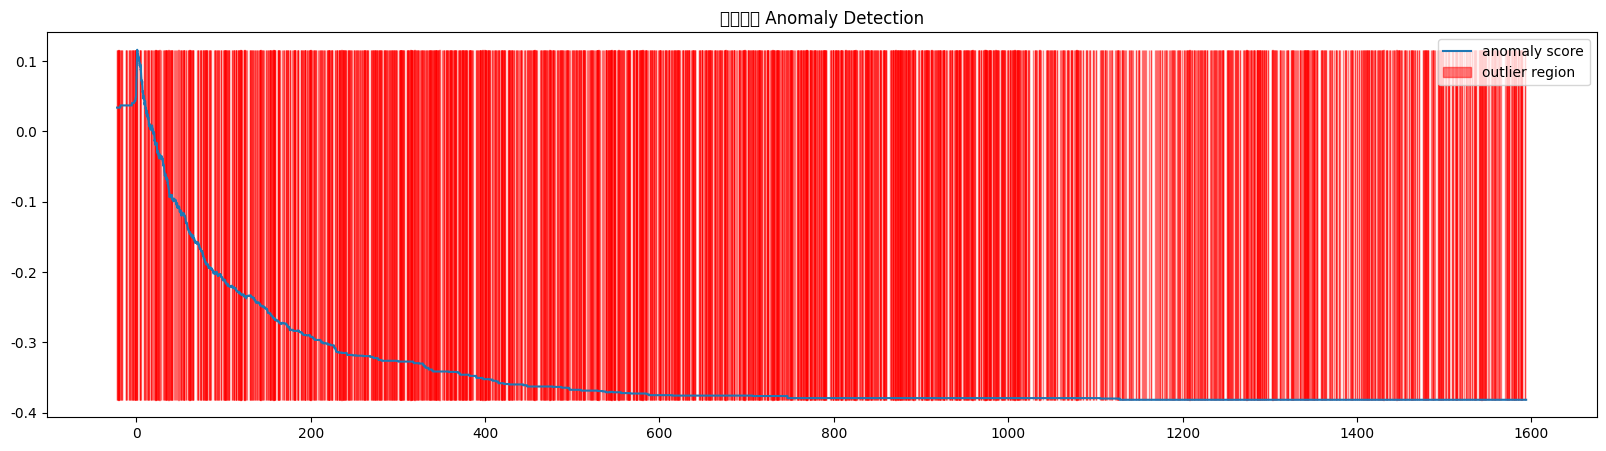

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
5,8801007070179,22,매출,51106,202537,CS,50,10,(CJ)헛개컨디션100ml,"음료,차류",음료,기능성음료,2021-01-31
9,8801019206825,24,매출,51106,201066,CS,144,12,(해태제과)1000자유시간36g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
19,8801043014793,632,매출,49409,201928,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2021-01-31
20,8801043014847,545,매출,49409,201928,CS,8,8,(농심)신라면멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
22,8801043015028,41,매출,49409,201928,CS,8,8,(농심)얼큰한너구리멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28398,18801046979492,23,매출,51669,200047,CS,12,12,(애경)항균트리오1kg,일상용품,세제용품,주방용합성세제,2023-12-26
28406,18801073181905,53,매출,51166,200996,CS,8,8,(삼양식품)삼양라면멀티120g*5,면류.라면류,라면류,봉지라면,2023-12-26
28408,18801073222219,47,매출,51203,200902,CS,16,16,(삼양식품)까르보불닭볶음면큰컵105g,면류.라면류,기타라면.면류,기타라면.면류,2023-12-26
28456,18809170703174,27,매출,51521,201637,CS,20/10,10,아망아망베이직물티슈캡형100매,일상용품,화장지류,물수건,2023-12-26


In [62]:
cols = ['판매수량']

# 그래프를 그리기 위해서 subplot 생성
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', edgecolor='k')

# Isolation Forest 모델 학습
isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(df3[cols].values.reshape(-1, 1))

# 이상치 탐지를 위한 예측
outlier = isolation_forest.predict(df3[cols].values.reshape(-1, 1))

# 이상치 점수 계산
xx = np.linspace(df3['판매수량'].min(), df3['판매수량'].max(), len(df3)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)

# 그래프 그리기
ax.plot(xx, anomaly_score, label='anomaly score')
ax.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                where=outlier == -1, color='r', alpha=0.5, label='outlier region')
ax.legend()
ax.set_title('판매수량 Anomaly Detection')
plt.show()

# 이상치 데이터 행 출력
df3_outliers4 = df3[outlier == -1]
df3_outliers4

## 공통 이상치만 출력 -> 공통 이상치 제외한 데이터프레임 생성

In [63]:
common_outliers3 = df3_outliers1.merge(df3_outliers2, on=list(df3_outliers1.columns), how='inner') \
                                 .merge(df3_outliers3, on=list(df3_outliers1.columns), how='inner') \
                                 .merge(df3_outliers4, on=list(df3_outliers1.columns), how='inner')

common_outliers3

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,8801043014793,632,매출,49409,201928,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2021-01-31
1,8801043014847,545,매출,49409,201928,CS,8,8,(농심)신라면멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
2,18801007424122,238,매출,50300,200531,CS,6,6,(CJ)햇반200g*6,가공식품류,레토르트식품,밥·반찬류,2021-01-31
3,18801037087540,140,매출,50855,200097,CS,24/20,20,(동서식품)TOP마스터라떼275ml,"음료,차류",음료,캔커피,2021-01-31
4,18801045522255,283,매출,50430,202595,CS,8,8,(오뚜기)진라면순한맛멀티120g*5,면류.라면류,라면류,봉지라면,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,18801045522286,242,매출,51163,202575,CS,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-11-28
342,8801043014793,182,매출,51527,202960,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2023-12-05
343,8801043014793,238,매출,51402,200040,CS,8,8,(농심)안성탕면멀티125g*5,면류.라면류,라면류,봉지라면,2023-12-12
344,18801045522286,279,매출,51402,201502,CS,8,8,(오뚜기)진라면매운맛멀티120g*5,면류.라면류,라면류,봉지라면,2023-12-12


In [64]:
# common_outliers3에 포함된 행을 df3에서 제거
df3_cleaned = df3.merge(common_outliers3, on=list(df3.columns), how='left', indicator=True)
df3_cleaned = df3_cleaned[df3_cleaned['_merge'] == 'left_only'].drop(columns=['_merge'])

df3_cleaned

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,34000723461,1,매출,51522,202574,CS,32,8,(롯데제과)아이스브레이커스민트42g,빵.케익.과자류,과자류,캔디류,2021-01-31
1,6921211116189,1,매출,51268,201813,CS,10,10,(농심)츄파춥스하트젤리복숭아크림향60g,빵.케익.과자류,과자류,캔디류,2021-01-31
2,8000500168028,2,매출,41836,200063,CS,48,24,킨더조이(남아)1구20g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
3,8000500168042,5,매출,51191,202522,CS,48,24,킨더조이(여아)1구20g,빵.케익.과자류,과자류,초콜릿류,2021-01-31
4,8717644460870,1,매출,51731,202105,CS,12,12,(유니레버)도브핸드워시(레귤러)250ml,일상용품,세제용품,기타비누세제류,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28484,68801051275133,7,매출,51357,200853,CS,3,3,(LG생활)샤프란핑크리필2.1L*2밴딩(3)_22Y,일상용품,세제용품,유연제,2023-12-26
28485,68801056071235,1,매출,51502,202765,CS,20,20,(델몬트)오리지널오렌지100_400ml,"음료,차류",음료,천연과즙음료,2023-12-26
28486,68801056071273,2,매출,51502,202765,CS,20,20,(델몬트)오리지널망고400ml,"음료,차류",음료,과즙·희석과즙음료,2023-12-26
28487,68801056090274,2,매출,52009,200817,CS,20/6,6,(롯데칠성)게토레이레몬600ml,"음료,차류",음료,스포츠음료,2023-12-26


In [65]:
# 엑셀 파일로 저장
df3_cleaned.to_excel('(2데이터)CS 이상치 제외_주 단위.xlsx', index=False)

## 최종. 옵션코드별 이상치 처리본 합치기

In [66]:
# '판매일'을 기준으로 데이터프레임 합치기
combined_df = pd.concat([df1_cleaned, df2_cleaned, df3_cleaned]).sort_values(by='판매일')

# 인덱스 초기화
combined_df.reset_index(drop=True, inplace=True)

# 엑셀 파일로 저장
combined_df.to_excel('(2데이터)옵션코드별 이상치 처리 병합_주 단위.xlsx', index=False)

combined_df

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,80135906,13,매출,51167,201736,EA,48,1,페레로로쉐(T-5),빵.케익.과자류,과자류,초콜릿류,2021-01-31
1,8809096576862,1,매출,51342,202560,EA,None,1,바스켓쟁반(퀸로즈)특대,생활잡화,기타생활잡화,기타생활잡화,2021-01-31
2,8809105117604,20,매출,52009,202096,EA,1,1,사각면봉(회오리형)200P,기타잡화,기타잡화,기타잡화,2021-01-31
3,8809112180486,3,매출,51513,200030,EA,1,1,할맥800g,신선식품,농산물,잡곡,2021-01-31
4,8809112180493,13,매출,51195,200186,EA,1,1,압맥800g,신선식품,농산물,잡곡,2021-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140012,8801046979525,2,매출,51389,202827,EA,4,1,(애경)항균트리오3kg,일상용품,세제용품,주방용합성세제,2023-12-26
140013,8801047111733,6,매출,52022,203529,EA,60,1,(동원)동원라이트스탠다드참치100g,통조림류,수산물병·통조림,수산물병·통조림,2023-12-26
140014,8801047111849,8,매출,51738,203483,EA,48,1,(동원)동원라이트스탠다드참치150g,통조림류,수산물병·통조림,수산물병·통조림,2023-12-26
140015,8801046400173,24,매출,51481,202170,EA,3,1,(애경)스파크프라임5.5kg리필,일상용품,세제용품,세탁용합성세제,2023-12-26
